In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# df = pd.read_csv('extracted_data1.csv')
df = pd.read_csv('test_data.csv')

In [5]:
df.drop(['credit_amount',
         'subscription_type_y'], axis=1, inplace=True)

In [6]:
''' Filled all the null values before encoding the data '''

for col in df.columns:
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({'Yes', 'No'}):
            df[col].fillna('No', inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)

In [7]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({'Yes', 'No'}):
            df[col].fillna('No', inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)
    return df

In [8]:
label_encoders = {}
label_col = ['jobma_catcher_industry', 'org_type']

def label_encoder(df):
    for col in label_col:
        if col in df.columns:
            if df[col].dtype == object or df[col].dtype.name == 'category':
                le_col = LabelEncoder()
                df[col] = le_col.fit_transform(df[col].astype(str))
                label_encoders = le_col

    return df

In [9]:
def ordinal_encoder(df):
    ordinal_col = ['jobma_catcher_is_deleted', 'company_size', 'plan_type', 'is_unlimited']
    
    is_deleted_order = ['Yes', 'No']
    company_size_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    plan_type_order = ['Unknown', 'No', 'Yes']
    is_unlimited_order = ['Unknown', 'No', 'Yes']

    ordinal_order = [is_deleted_order, company_size_order, plan_type_order, is_unlimited_order]

    ordinal = OrdinalEncoder(categories=ordinal_order)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    df.drop(columns=ordinal_col, inplace=True)

    df = pd.concat([df, encoded_df], axis=1)
    
    return df

In [10]:
log_cols = [
    'wallet_amount',
    'subscription_amount',
    'number_of_invitations',
    'job_posted',
    'number_of_kits',
    'interview_question',
    'pre_recorded_credit',
    'live_interview_credit'
]

In [11]:
def log_transform(df):
    df = df.copy()
    for col in log_cols:
        if col in df.columns:
            # fill NaNs
            df[col] = df[col].fillna(0)
            # if a number is less than zero, turn it into zero;
            df[col] = df[col].clip(lower=0)
            # safe log1p
            df[col] = np.log1p(df[col])
    return df

In [12]:
pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    ('log_transformation', FunctionTransformer(log_transform, validate=False)), # log transforms the col with outliers
    ('scaler', StandardScaler()), # Needs attention to improve model
    ('pca', PCA(n_components=0.97))
])

In [13]:
X = df

In [14]:
X_transformed = pipeline.fit_transform(X)

In [15]:
X_df = pd.DataFrame(X_transformed)

In [16]:
X_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [18]:
X_data = CustomDataset(X_tensor)

In [19]:
dataloader = DataLoader(X_data, batch_size=8, shuffle=False)

In [20]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        ''' Encoder (Compression) '''
        # Shrinks job data into a small hidden representation (like a summary).
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        ''' Decoder (Reconstruction) '''
        # Tries to rebuild the original job data from that compressed version.
        self.decoder = nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [21]:
''' Initializing the model '''
input_shape = X_df.shape[1]

model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=20, bias=True)
  )
)

In [22]:
''' Important Parameters '''

learning_rate = 1e-4
epochs = 20

In [23]:
''' Loss Function and Optimizer '''

# cosine_loss_function = nn.CosineEmbeddingLoss()
mse_loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate, weight_decay=1e-5)
# LR Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [24]:
torch.manual_seed(42)

model_1.train()
model_1.to(device)

# Early Stopping Setup
best_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(epochs):
    epoch_total_loss = 0

    for batch_X in dataloader:
        batch_X = batch_X.to(device)

        # Forward pass
        encoded, decoded = model_1(batch_X)

        # Reconstruction Loss
        mse_loss = mse_loss_function(decoded, batch_X)

        # Backpropagation
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

        epoch_total_loss += mse_loss.item()

    # Average loss over all batches in the epoch
    training_loss = epoch_total_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f}')

    # Early Stopping logic
    if training_loss < best_loss:
        best_loss = training_loss
        trigger_times = 0
        torch.save(model_1.state_dict(), "best_autoencoder.pth")  # Save best model
    else:
        trigger_times += 1
        print(f"Early stopping trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping activated.")
            break

    scheduler.step()  # Step the LR scheduler

Epoch 1/20 | Training Loss: 0.94503
Epoch 2/20 | Training Loss: 0.62660
Epoch 3/20 | Training Loss: 0.52570
Epoch 4/20 | Training Loss: 0.44148
Epoch 5/20 | Training Loss: 0.38809
Epoch 6/20 | Training Loss: 0.35407
Epoch 7/20 | Training Loss: 0.31880
Epoch 8/20 | Training Loss: 0.28448
Epoch 9/20 | Training Loss: 0.25116
Epoch 10/20 | Training Loss: 0.22132
Epoch 11/20 | Training Loss: 0.19764
Epoch 12/20 | Training Loss: 0.18223
Epoch 13/20 | Training Loss: 0.16927
Epoch 14/20 | Training Loss: 0.15695
Epoch 15/20 | Training Loss: 0.14522
Epoch 16/20 | Training Loss: 0.13401
Epoch 17/20 | Training Loss: 0.12395
Epoch 18/20 | Training Loss: 0.11439
Epoch 19/20 | Training Loss: 0.10620
Epoch 20/20 | Training Loss: 0.09858


In [25]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_tensor)

latent_np = encoder.cpu().numpy()

In [26]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [27]:
torch.manual_seed(42)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

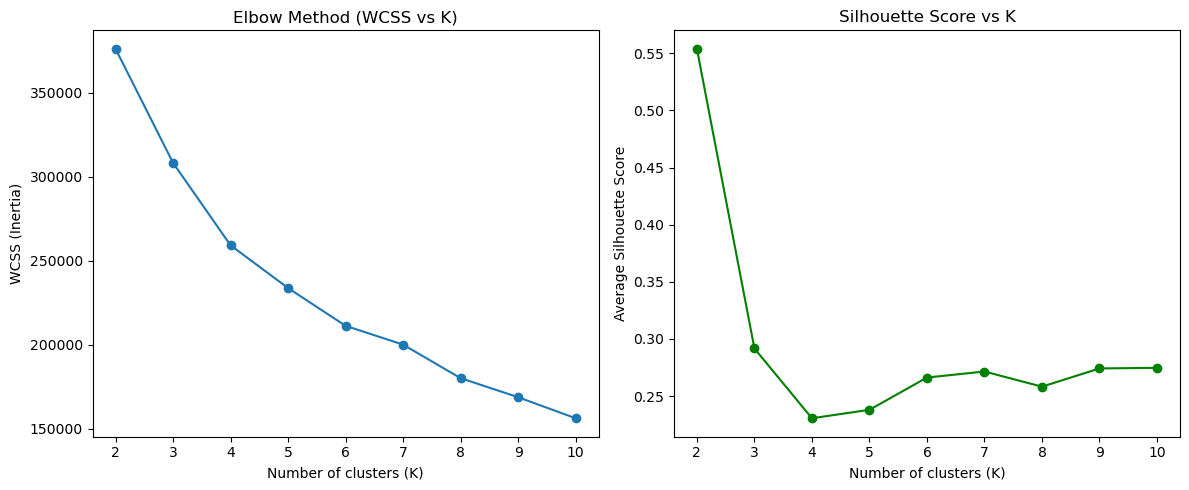

In [28]:
''' Elbow Rule to decide the number of clusters '''
torch.manual_seed(42)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [29]:
#Initialising KMeans
kmeans = KMeans(n_clusters=3, n_init=50, init='k-means++', random_state=42)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

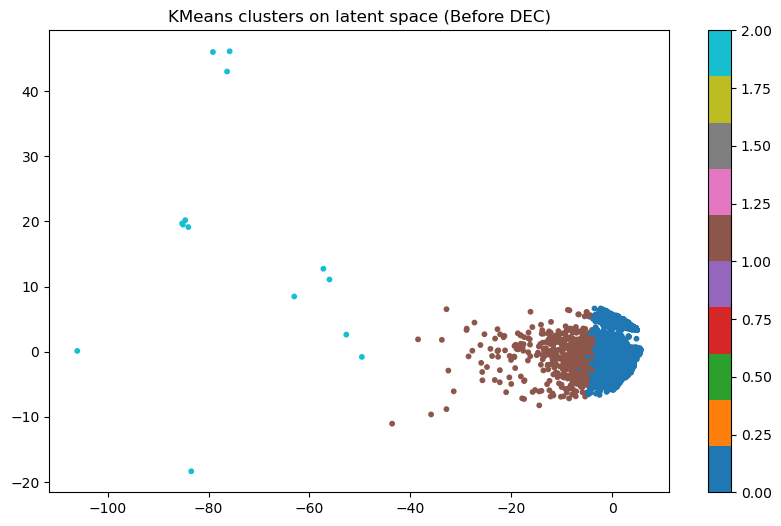

In [30]:
latent_2d = PCA(n_components=2).fit_transform(latent_np)
plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_ids, cmap='tab10', s=10)
plt.title("KMeans clusters on latent space (Before DEC)")
plt.colorbar()
plt.show()

In [31]:
# Deep Embedding Clusturing Model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super(DEC, self).__init__()
        self.encoder = encoder
        self.cluster_centers = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q.pow((1 + 1) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()  

In [32]:
''' Initializing DEC Model '''
dec = DEC(model_1.encoder, cluster_centers.clone()).to(device)

In [33]:
''' Loss Function and Optimizer '''

kl_loss = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(dec.parameters(), lr=5e-4)
batch_size = dataloader.batch_size

In [34]:
dec.train()
num_epochs = 50
for epoch in range(num_epochs):
    # Compute global soft assignments q_all
    with torch.no_grad():
        q_all, _ = dec(X_tensor.to(device))            
        p_all = target_distribution(q_all)              

    epoch_loss = 0.0
    for batch_idx, batch in enumerate(dataloader):
        x = batch.to(device)
        q_batch, _ = dec(x)                            

        # Slice the matching rows from p_all
        start = batch_idx * batch_size
        end   = start + x.size(0)
        p_batch = p_all[start:end].to(device)          

        # Compute loss against the global target
        loss = kl_loss(torch.log(q_batch + 1e-8), p_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)

    avg_loss = epoch_loss / len(X_tensor)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg KL Loss: {avg_loss:.4f}")

Epoch 1/50, Avg KL Loss: 0.0078
Epoch 2/50, Avg KL Loss: 0.0167
Epoch 3/50, Avg KL Loss: 0.0280
Epoch 4/50, Avg KL Loss: 0.0333
Epoch 5/50, Avg KL Loss: 0.0358
Epoch 6/50, Avg KL Loss: 0.0353
Epoch 7/50, Avg KL Loss: 0.0338
Epoch 8/50, Avg KL Loss: 0.0324
Epoch 9/50, Avg KL Loss: 0.0307
Epoch 10/50, Avg KL Loss: 0.0287
Epoch 11/50, Avg KL Loss: 0.0274
Epoch 12/50, Avg KL Loss: 0.0259
Epoch 13/50, Avg KL Loss: 0.0255
Epoch 14/50, Avg KL Loss: 0.0256
Epoch 15/50, Avg KL Loss: 0.0243
Epoch 16/50, Avg KL Loss: 0.0236
Epoch 17/50, Avg KL Loss: 0.0231
Epoch 18/50, Avg KL Loss: 0.0227
Epoch 19/50, Avg KL Loss: 0.0228
Epoch 20/50, Avg KL Loss: 0.0222
Epoch 21/50, Avg KL Loss: 0.0218
Epoch 22/50, Avg KL Loss: 0.0215
Epoch 23/50, Avg KL Loss: 0.0215
Epoch 24/50, Avg KL Loss: 0.0212
Epoch 25/50, Avg KL Loss: 0.0206
Epoch 26/50, Avg KL Loss: 0.0203
Epoch 27/50, Avg KL Loss: 0.0202
Epoch 28/50, Avg KL Loss: 0.0204
Epoch 29/50, Avg KL Loss: 0.0195
Epoch 30/50, Avg KL Loss: 0.0195
Epoch 31/50, Avg KL

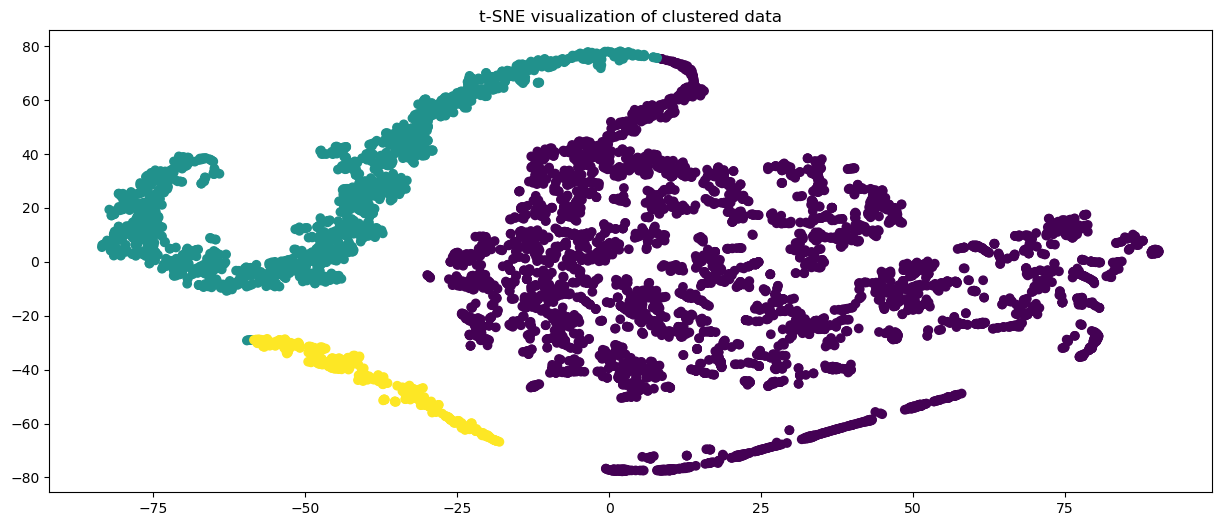

In [35]:
''' Visualizing the Clusters '''

dec.eval()

with torch.no_grad():
    q, _ = dec(X_tensor.to(device))  # Get cluster assignments
    preds = torch.argmax(q, dim=1).cpu().numpy()

with torch.no_grad():
    _, z= dec(X_tensor.to(device)) # Get embedded features
    # Reduce dimensions for visualization (using t-SNE)
    z_2d = TSNE(n_components=2).fit_transform(z.cpu().numpy())

    # Visualize the clusters (color = cluster assignments)
    plt.figure(figsize=(15,6))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=preds, cmap='viridis')
    plt.title('t-SNE visualization of clustered data')
    plt.show()

In [36]:
''' Add cluster labels to original dataframe '''
df_train = df.iloc[-X_tensor.shape[0]:].copy()
df_train['cluster_id'] = preds

In [37]:
cluster_summary = df_train.groupby('cluster_id').mean(numeric_only=True)
cluster_summary

,jobma_catcher_id,org_type,jobma_catcher_type,is_premium,jobma_catcher_sub_accounts,jobma_verified,subscription_status,interview_rate,live_interview_credit,pre_recorded_credit,...,video_recording_suppport,sing_up_canditate_after_apply,currency,wallet_amount,premium_storage,subscription_amount,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,5973.793357,0.102728,0.644365,0.139502,0.0,1.00000,1.621352,0.0,1.000237,1.001661,...,2.0,0.0,0.397628,52.795492,0.0,53498.803834,1.066667,0.266667,0.093001,0.084698
1,8159.117001,0.230769,0.780220,0.180349,0.0,1.00000,1.334842,0.0,1.008403,1.049127,...,2.0,0.0,0.407886,33546.892696,0.0,126307.190802,2.001293,6.703943,1.059470,1.079509
2,6709.988701,0.062147,0.926554,0.336158,0.0,0.99435,1.593220,0.0,0.663842,35.850254,...,2.0,0.0,0.638418,26139.539548,0.0,156968.241864,5.248588,206.768362,8.550847,10.073446


In [38]:
unique_clusters = np.unique(preds)
print(f"Unique Clusters Found: {len(unique_clusters)} -> {unique_clusters}")

Unique Clusters Found: 3 -> [0 1 2]
